<a href="https://colab.research.google.com/github/mst-projects/numerai/blob/main/hyper_parameter_optimization_by_optuna_using_tf_keras_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
pip install optuna

In [2]:
import gc
import warnings
warnings.simplefilter('ignore')

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import pandas as pd
import random as python_random
from sklearn.model_selection import TimeSeriesSplit

In [21]:
np.random.seed(1)
python_random.seed(1)
tf.random.set_seed(1)

In [22]:
# CONSTANTS:
TOURNAMENT_NAME = ""
TARGET_NAME = f"target{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction{TOURNAMENT_NAME}"

In [12]:
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
training_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.50,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.50,1.00,0.50,0.00,0.50,0.50,0.00,0.00,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.50,0.50,0.75,0.50,...,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.50,0.25,0.25,0.75,0.50,1.00,0.50,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.50,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.50,0.50,0.50,0.50,0.25,0.25,0.50,0.00,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.50,0.25,0.75,0.50,...,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.00,0.25,1.00,0.50,1.00,1.00,0.50,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.50,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.50,0.50,1.00,0.50,0.50,0.50,0.25,0.00,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.50,0.50,0.75,0.50,...,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.50,1.00,0.00,1.00,1.00,0.50,1.00,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.00,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.50,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.00,0.50,0.50,0.00,1.00,0.00,0.75,0.00,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.50,0.50,0.50,0.50,...,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.00,0.75,1.00,0.75,1.00,0.75,1.00,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.50,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.00,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.00,0.50,0.50,0.25,0.00,0.50,0.00,0.50,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.50,0.50,0.50,0.50,...,1.00,0.25,0.75,1.00,0.75,0.00,0.00,0.75,0.50,1.00,0.50,0.75,0.25,0.50,0.00,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.50,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501803,nff6a8a8feaeeb52,era120,train,0.50,0.50,0.25,0.00,0.00,0.50,0.75,0.00,0.75,0.75,0.25,0.00,1.00,0.00,0.75,0.00,0.50,1.00,0.25,0.25,0.00,0.50,0.75,0.

In [23]:
train_eras = [f'era{i}'for i in range(1, 91)]
test_eras =[f'era{i}' for i in range(91, 121)]

train_df = training_data[training_data['era'].isin(train_eras)]
test_df = training_data[training_data['era'].isin(test_eras)]

In [24]:
def plot_the_loss_curve(epochs, mse):
    """Plot a curve of loss vs. epoch."""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.plot(epochs, mse, label="Loss")
    plt.legend()
    plt.ylim([mse.min() * 0.95, mse.max() * 1.03])
    plt.draw()

def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def sharpe(x):
    return np.mean(x)/np.std(x, ddof=1)

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def sortino_ratio(x, target=0.010415154):
   xt = x# - target
   return np.mean(xt) / (np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5

def score(df):
    # method="first" breaks ties based on order in array
    pct_ranks = df[PREDICTION_NAME].rank(pct=True, method="first")
    targets = df[TARGET_NAME]
    return np.corrcoef(targets, pct_ranks)[0, 1]

In [25]:
# FEATURES
feature_names = [
    f for f in training_data.columns if f.startswith("feature")
]
# print(f"Loaded {len(feature_names)} features columns")

train_features = train_df[feature_names]
train_target = train_df[TARGET_NAME]

test_features = test_df[feature_names]
test_target = test_df[TARGET_NAME]


# print(':::::: train_Features ::::::', '\n', train_Features)
# print(':::::: train_Target ::::::', '\n', train_Target)

# # Parameters (not optimized):
# lr = 0.001
epochs = 75
# batch_size = 1000
# layer_Size = 32

In [26]:
def build_model(learning_rate, layer_size1, layer_size2, l2, dropout):
    """Build Keras model"""
    model = keras.Sequential([
      layers.Dense(layer_size1, activation='relu',input_shape=[len(feature_names)]),
#       layers.Dropout(0.5),
      layers.Dense(layer_size2, activation='relu'
                   , kernel_regularizer=tf.keras.regularizers.l2(l2)
                  ),
#       layers.Dropout(0.3),
#                    bias_regularizer=tf.keras.regularizers.l2(0.001)
#                   ),
#       layers.Dense(layer_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001),
#                    bias_regularizer=tf.keras.regularizers.l2(0.001)
#                   ),
#       layers.LeakyReLU(alpha=0.1),
#       layers.Dense(layer_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      layers.Dropout(dropout),
      layers.Dense(1, activation=('sigmoid'))
                   ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

def train_model(model, feature, label, epochs, batch_size):
    """Train Keras Model"""
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="log_dir", histogram_freq=1)
#     early_stopping_callback = tf.keras.callbacks.EalryStopping()
    history = model.fit(x=feature,
                        y=label,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
#                         callbacks=[tensorboard_callback]
                       )
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    mse = hist["mse"]
    return epochs, mse

[I 2021-12-31 23:41:30,251] A new study created in memory with name: no-name-537dbdbe-b547-429d-add7-0139b8abf6da
[I 2021-12-31 23:45:49,324] Trial 0 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.007030349771869778, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.00023045707025783348, 'dropout': 0.5, 'batch_size': 293}. Best is trial 0 with value: 0.0005484460335629153.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2021-12-31 23:48:16,171] Trial 1 finished with value: 0.024840809965009113 and parameters: {'learning_rate': 0.0002931852877299053, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.00028728914737025714, 'dropout': 0.5, 'batch_size': 545}. Best is trial 1 with value: 0.024840809965009113.


On test the correlation has mean 0.024840809965009113 and std 0.020697957055318884
sharpe:  1.2001575758717506


[I 2021-12-31 23:51:01,972] Trial 2 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0007716947147516834, 'layer_size1': 64, 'layer_size2': 32, 'l2': 0.00013667578590935558, 'dropout': 0.7, 'batch_size': 470}. Best is trial 1 with value: 0.024840809965009113.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2021-12-31 23:55:25,652] Trial 3 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0004680729127973655, 'layer_size1': 32, 'layer_size2': 64, 'l2': 0.0042434013634321125, 'dropout': 0.6, 'batch_size': 280}. Best is trial 1 with value: 0.024840809965009113.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2021-12-31 23:58:31,271] Trial 4 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0020943116078335484, 'layer_size1': 32, 'layer_size2': 128, 'l2': 0.0001764096545203597, 'dropout': 0.5, 'batch_size': 412}. Best is trial 1 with value: 0.024840809965009113.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:01:09,680] Trial 5 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0017263678009506944, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.004287948577050467, 'dropout': 0.5, 'batch_size': 496}. Best is trial 1 with value: 0.024840809965009113.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:04:57,150] Trial 6 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.008982013672527114, 'layer_size1': 32, 'layer_size2': 64, 'l2': 0.0010608468362639277, 'dropout': 0.5, 'batch_size': 327}. Best is trial 1 with value: 0.024840809965009113.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:06:38,431] Trial 7 finished with value: 0.02196581413658836 and parameters: {'learning_rate': 0.000292246534613469, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.00023040110378214242, 'dropout': 0.7, 'batch_size': 871}. Best is trial 1 with value: 0.024840809965009113.


On test the correlation has mean 0.02196581413658836 and std 0.02179888104829639
sharpe:  1.0076578741781341


[I 2022-01-01 00:10:32,416] Trial 8 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.003567710732478579, 'layer_size1': 32, 'layer_size2': 128, 'l2': 0.0005848562350635605, 'dropout': 0.5, 'batch_size': 315}. Best is trial 1 with value: 0.024840809965009113.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:12:43,516] Trial 9 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0005538555329877891, 'layer_size1': 64, 'layer_size2': 32, 'l2': 0.0021460018074311218, 'dropout': 0.6, 'batch_size': 621}. Best is trial 1 with value: 0.024840809965009113.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:14:24,760] Trial 10 finished with value: 0.029304968691496715 and parameters: {'learning_rate': 0.00011684661551863503, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.000595099518470631, 'dropout': 0.6, 'batch_size': 864}. Best is trial 10 with value: 0.029304968691496715.


On test the correlation has mean 0.029304968691496715 and std 0.021082912022418392
sharpe:  1.3899867656012341


[I 2022-01-01 00:16:01,318] Trial 11 finished with value: 0.02555344521494447 and parameters: {'learning_rate': 0.00014830318978345373, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0006258531099874389, 'dropout': 0.6, 'batch_size': 922}. Best is trial 10 with value: 0.029304968691496715.


On test the correlation has mean 0.02555344521494447 and std 0.022299678564808377
sharpe:  1.145910921571351


[I 2022-01-01 00:17:34,526] Trial 12 finished with value: 0.02905425897900397 and parameters: {'learning_rate': 0.00010082681806721648, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0007590250211565662, 'dropout': 0.6, 'batch_size': 965}. Best is trial 10 with value: 0.029304968691496715.


On test the correlation has mean 0.02905425897900397 and std 0.024083764362270634
sharpe:  1.2063836259966096


[I 2022-01-01 00:19:03,647] Trial 13 finished with value: 0.030825826818031535 and parameters: {'learning_rate': 0.00010600708077551886, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.001453150092851215, 'dropout': 0.6, 'batch_size': 1011}. Best is trial 13 with value: 0.030825826818031535.


On test the correlation has mean 0.030825826818031535 and std 0.026683915351656203
sharpe:  1.1552212788787106


[I 2022-01-01 00:20:51,693] Trial 14 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.00016607181378989623, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.009936218783739651, 'dropout': 0.7, 'batch_size': 789}. Best is trial 13 with value: 0.030825826818031535.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:22:21,260] Trial 15 finished with value: 0.02406343408152483 and parameters: {'learning_rate': 0.000229786994359015, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0014297789725679357, 'dropout': 0.6, 'batch_size': 1018}. Best is trial 13 with value: 0.030825826818031535.


On test the correlation has mean 0.02406343408152483 and std 0.025646919670602664
sharpe:  0.9382582544252721


[I 2022-01-01 00:24:11,618] Trial 16 finished with value: 0.02516019495955268 and parameters: {'learning_rate': 0.00010152408151255475, 'layer_size1': 128, 'layer_size2': 32, 'l2': 0.00041125622415861667, 'dropout': 0.6, 'batch_size': 763}. Best is trial 13 with value: 0.030825826818031535.


On test the correlation has mean 0.02516019495955268 and std 0.022112949814792286
sharpe:  1.1378036476491238


[I 2022-01-01 00:25:59,151] Trial 17 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0004607133354128803, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0020710210076966143, 'dropout': 0.7, 'batch_size': 802}. Best is trial 13 with value: 0.030825826818031535.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:27:57,037] Trial 18 finished with value: 0.03238422100117642 and parameters: {'learning_rate': 0.00018256956221319255, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0014694538004351317, 'dropout': 0.6, 'batch_size': 708}. Best is trial 18 with value: 0.03238422100117642.


On test the correlation has mean 0.03238422100117642 and std 0.027610759153338136
sharpe:  1.1728841217776214


[I 2022-01-01 00:29:57,343] Trial 19 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.00022097537959910895, 'layer_size1': 128, 'layer_size2': 32, 'l2': 0.0030816395699819277, 'dropout': 0.7, 'batch_size': 686}. Best is trial 18 with value: 0.03238422100117642.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:31:58,159] Trial 20 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0012182061681211252, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.008469808454586811, 'dropout': 0.6, 'batch_size': 675}. Best is trial 18 with value: 0.03238422100117642.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:33:39,051] Trial 21 finished with value: 0.030448858698223898 and parameters: {'learning_rate': 0.0001454644938862049, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.001345950536217307, 'dropout': 0.6, 'batch_size': 870}. Best is trial 18 with value: 0.03238422100117642.


On test the correlation has mean 0.030448858698223898 and std 0.028116478428734028
sharpe:  1.0829542104784453


[I 2022-01-01 00:35:08,228] Trial 22 finished with value: 0.02818426481650573 and parameters: {'learning_rate': 0.00018093078065231408, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0014049935022539893, 'dropout': 0.6, 'batch_size': 1022}. Best is trial 18 with value: 0.03238422100117642.


On test the correlation has mean 0.02818426481650573 and std 0.022471452476913855
sharpe:  1.2542253263540022


[I 2022-01-01 00:36:44,832] Trial 23 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.000283725679815612, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0012367872021533189, 'dropout': 0.6, 'batch_size': 904}. Best is trial 18 with value: 0.03238422100117642.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:38:40,243] Trial 24 finished with value: 0.03249805657635084 and parameters: {'learning_rate': 0.00014031528191015344, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0020198644079512393, 'dropout': 0.6, 'batch_size': 728}. Best is trial 24 with value: 0.03249805657635084.


On test the correlation has mean 0.03249805657635084 and std 0.024967499066064
sharpe:  1.3016144104125522


[I 2022-01-01 00:40:55,122] Trial 25 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.000352532213444987, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0021364381908452706, 'dropout': 0.6, 'batch_size': 602}. Best is trial 24 with value: 0.03249805657635084.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:42:48,552] Trial 26 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0006982327669884994, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0031148775156025457, 'dropout': 0.7, 'batch_size': 741}. Best is trial 24 with value: 0.03249805657635084.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:44:45,246] Trial 27 finished with value: 0.022696543655394554 and parameters: {'learning_rate': 0.00019074110267464737, 'layer_size1': 128, 'layer_size2': 64, 'l2': 0.0008900651874064219, 'dropout': 0.6, 'batch_size': 716}. Best is trial 24 with value: 0.03249805657635084.


On test the correlation has mean 0.022696543655394554 and std 0.02081545913828402
sharpe:  1.0903695904382344


[I 2022-01-01 00:47:03,540] Trial 28 finished with value: 0.036646857480345796 and parameters: {'learning_rate': 0.00013727720758638801, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.005953189505330165, 'dropout': 0.6, 'batch_size': 579}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.036646857480345796 and std 0.03479262912808864
sharpe:  1.053293711878767


[I 2022-01-01 00:49:21,865] Trial 29 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0037938173231965976, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.006885584155490483, 'dropout': 0.5, 'batch_size': 579}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 00:51:25,424] Trial 30 finished with value: 0.030018842084290443 and parameters: {'learning_rate': 0.00035487220533947736, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.005985652405814427, 'dropout': 0.6, 'batch_size': 660}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.030018842084290443 and std 0.030081579883322083
sharpe:  0.9979144114346726


[I 2022-01-01 00:53:56,061] Trial 31 finished with value: 0.03337240796735553 and parameters: {'learning_rate': 0.00012327011580480233, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.0028406087846079685, 'dropout': 0.6, 'batch_size': 528}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.03337240796735553 and std 0.025879813518180268
sharpe:  1.2895150092141043


[I 2022-01-01 00:56:24,558] Trial 32 finished with value: 0.03414595788674941 and parameters: {'learning_rate': 0.00014496234920076807, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.0035194814424468284, 'dropout': 0.6, 'batch_size': 531}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.03414595788674941 and std 0.028601728393531197
sharpe:  1.1938424635369986


[I 2022-01-01 00:58:52,958] Trial 33 finished with value: 0.03211651159956041 and parameters: {'learning_rate': 0.00013987863071116726, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.004685607894097291, 'dropout': 0.6, 'batch_size': 529}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.03211651159956041 and std 0.0235502748666299
sharpe:  1.3637425372503247


[I 2022-01-01 01:01:42,422] Trial 34 finished with value: 0.029892155569379 and parameters: {'learning_rate': 0.00025351831277910236, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.003324213426280742, 'dropout': 0.6, 'batch_size': 456}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.029892155569379 and std 0.02492374705248768
sharpe:  1.1993443644901465


[I 2022-01-01 01:04:44,764] Trial 35 finished with value: 0.03272702454568099 and parameters: {'learning_rate': 0.00013498170202530616, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.005830970540590611, 'dropout': 0.5, 'batch_size': 417}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.03272702454568099 and std 0.027247418486603763
sharpe:  1.2011055125009835


[I 2022-01-01 01:07:59,412] Trial 36 finished with value: 0.025216184039305093 and parameters: {'learning_rate': 0.00039289937084034573, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.005314102388398283, 'dropout': 0.5, 'batch_size': 387}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.025216184039305093 and std 0.036251909576624455
sharpe:  0.6955822281859797


[I 2022-01-01 01:10:23,479] Trial 37 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0009541121762696735, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.007691261893260484, 'dropout': 0.5, 'batch_size': 550}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 01:13:21,687] Trial 38 finished with value: 0.030041680001825954 and parameters: {'learning_rate': 0.00012757387640238287, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.0038266109085151262, 'dropout': 0.5, 'batch_size': 430}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.030041680001825954 and std 0.030581117372425304
sharpe:  0.9823604427519789


[I 2022-01-01 01:16:43,343] Trial 39 finished with value: 0.03068135655395903 and parameters: {'learning_rate': 0.00021462822936378246, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.005898227848455899, 'dropout': 0.5, 'batch_size': 368}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.03068135655395903 and std 0.024812133005901276
sharpe:  1.2365465132184255


[I 2022-01-01 01:19:17,757] Trial 40 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.0051868598417383425, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.0029795194071355613, 'dropout': 0.7, 'batch_size': 503}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 01:21:39,516] Trial 41 finished with value: 0.030734434092330634 and parameters: {'learning_rate': 0.00013637394085538364, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.002371887116917585, 'dropout': 0.6, 'batch_size': 572}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.030734434092330634 and std 0.02836182266702533
sharpe:  1.0836551110681545


[I 2022-01-01 01:24:14,972] Trial 42 finished with value: 0.03139616415415112 and parameters: {'learning_rate': 0.0001754550145772715, 'layer_size1': 32, 'layer_size2': 128, 'l2': 0.00405719393896756, 'dropout': 0.5, 'batch_size': 496}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.03139616415415112 and std 0.030346007304762095
sharpe:  1.034606096243318


[I 2022-01-01 01:28:57,789] Trial 43 finished with value: 0.0277959682429757 and parameters: {'learning_rate': 0.0001293176099163763, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.0026070323527390008, 'dropout': 0.6, 'batch_size': 257}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.0277959682429757 and std 0.028072142855642437
sharpe:  0.9901619689637898


[I 2022-01-01 01:31:50,999] Trial 44 finished with value: 0.03393314787260994 and parameters: {'learning_rate': 0.00028822116420944966, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.00494581754763283, 'dropout': 0.6, 'batch_size': 449}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.03393314787260994 and std 0.02768043995706767
sharpe:  1.2258890366352635


[I 2022-01-01 01:34:41,855] Trial 45 finished with value: 0.030357425170533064 and parameters: {'learning_rate': 0.00029699645669832065, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.004835690820638396, 'dropout': 0.5, 'batch_size': 454}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.030357425170533064 and std 0.02820294320957202
sharpe:  1.0763920965606815


[I 2022-01-01 01:38:09,306] Trial 46 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.001961146703422009, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.00701292854678394, 'dropout': 0.7, 'batch_size': 364}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 01:41:13,824] Trial 47 finished with value: 0.0005484460335629153 and parameters: {'learning_rate': 0.000568991538488354, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.009573541537687563, 'dropout': 0.6, 'batch_size': 418}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.0005484460335629153 and std 0.01515159740361404
sharpe:  0.03619724171341149


[I 2022-01-01 01:43:23,369] Trial 48 finished with value: 0.03489553607121674 and parameters: {'learning_rate': 0.00011446787837471117, 'layer_size1': 64, 'layer_size2': 128, 'l2': 0.006087591713620027, 'dropout': 0.6, 'batch_size': 637}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.03489553607121674 and std 0.02926939549365741
sharpe:  1.1922192270345486


[I 2022-01-01 01:45:36,681] Trial 49 finished with value: 0.036170024023285625 and parameters: {'learning_rate': 0.00010110937801081872, 'layer_size1': 32, 'layer_size2': 32, 'l2': 0.0037948961350825028, 'dropout': 0.6, 'batch_size': 623}. Best is trial 28 with value: 0.036646857480345796.


On test the correlation has mean 0.036170024023285625 and std 0.036150861282224174
sharpe:  1.000530077026709


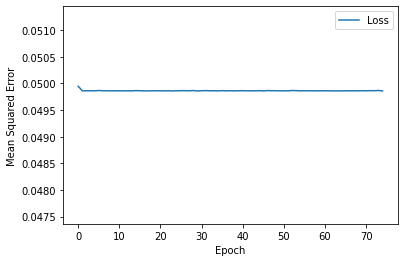

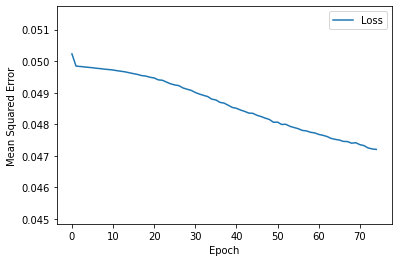

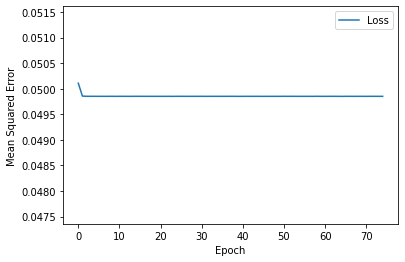

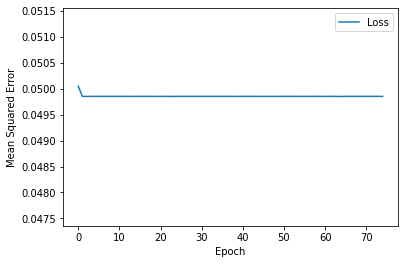

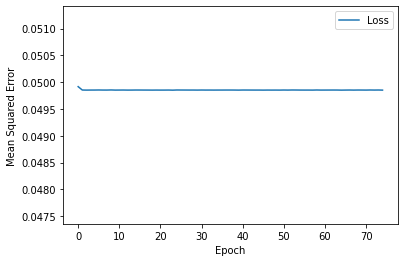

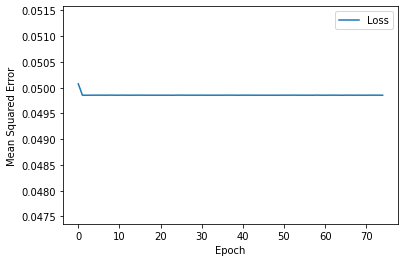

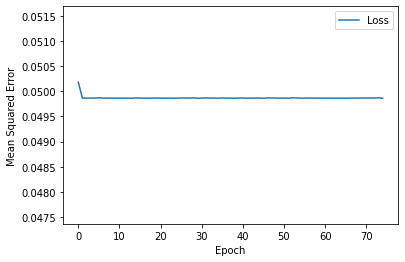

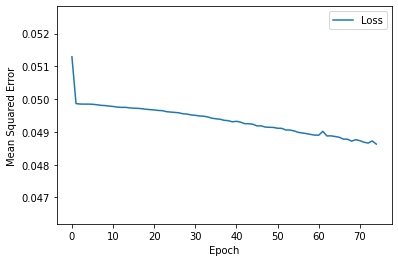

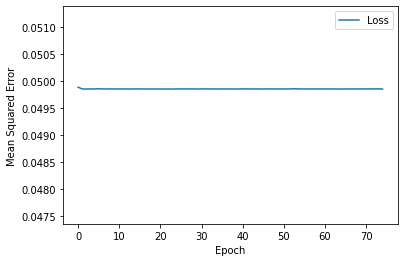

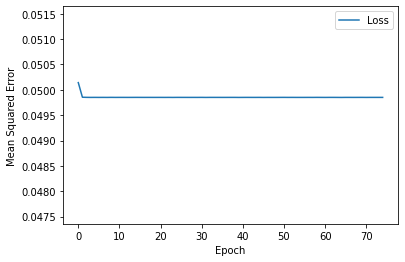

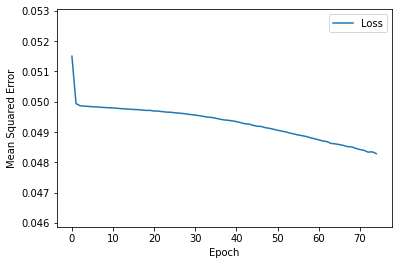

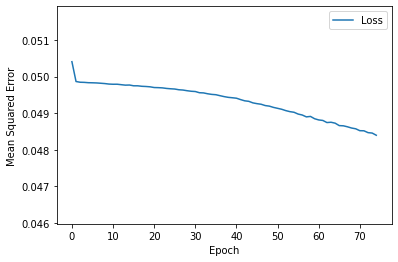

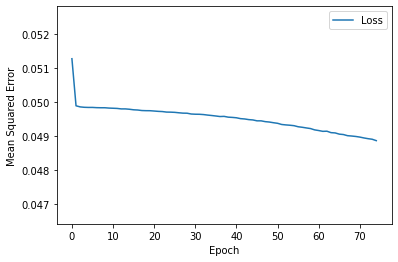

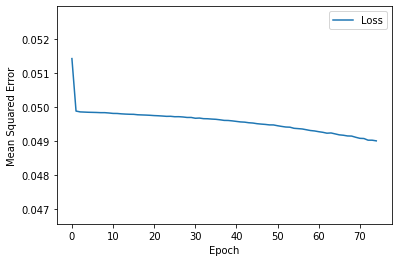

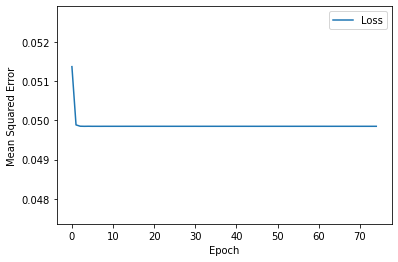

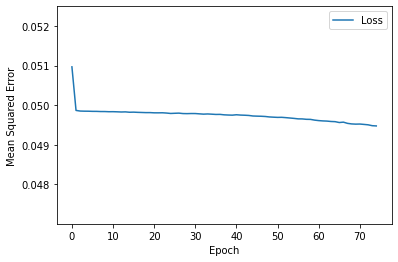

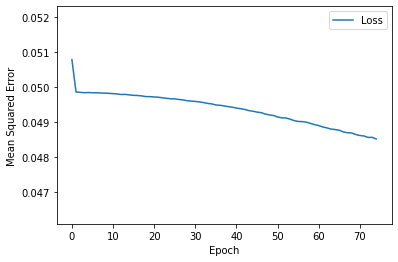

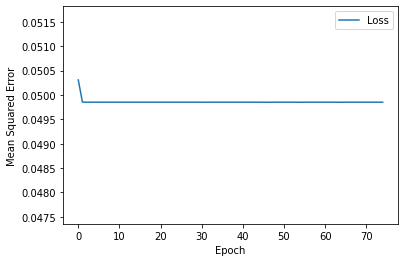

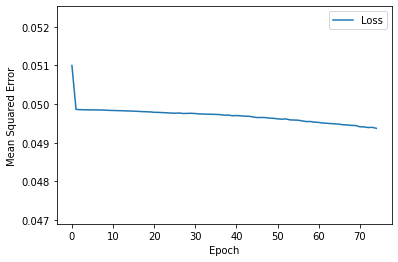

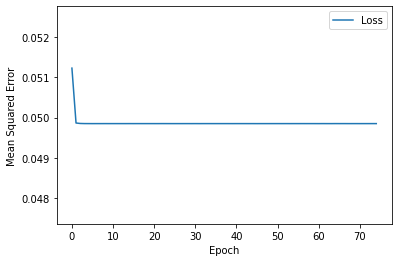

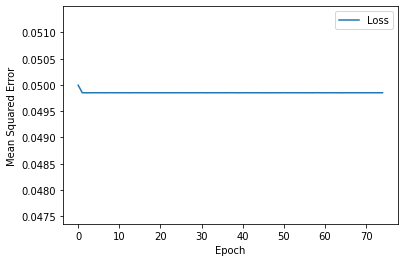

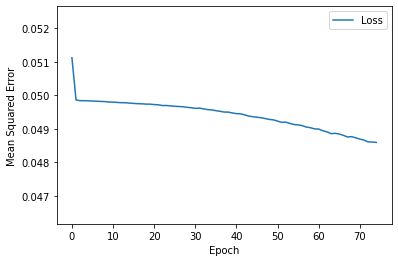

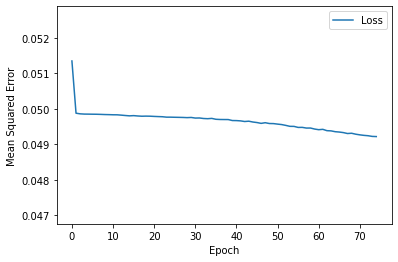

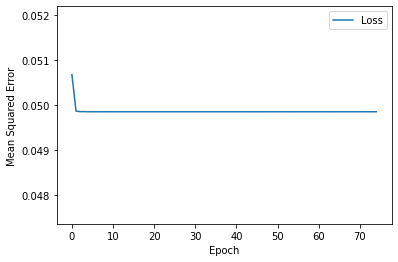

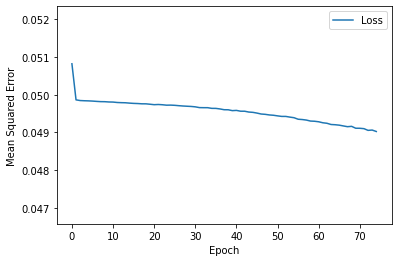

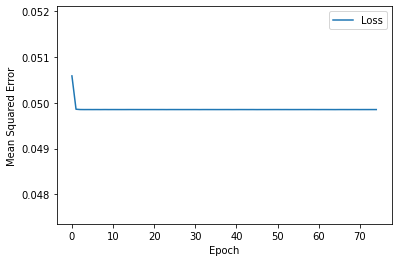

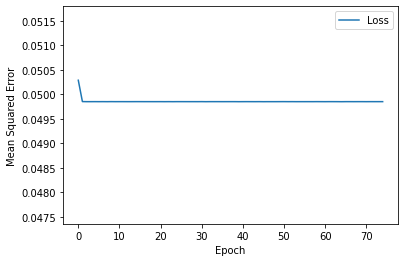

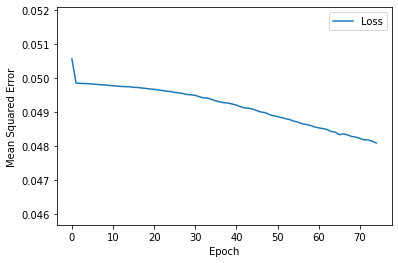

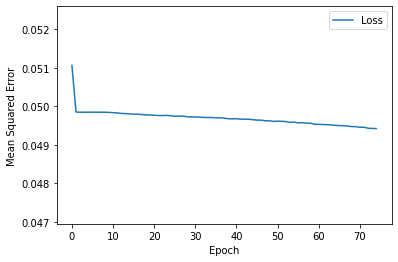

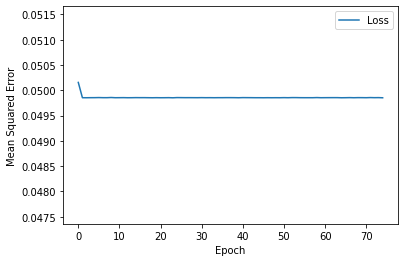

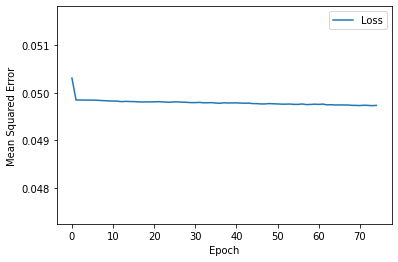

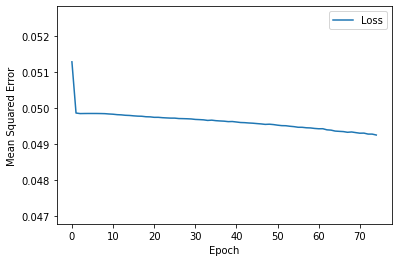

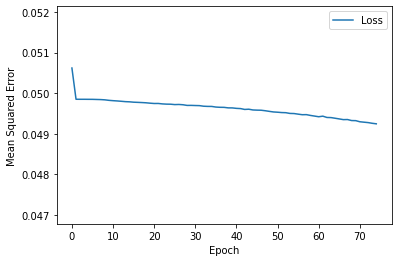

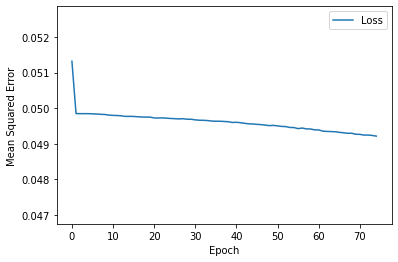

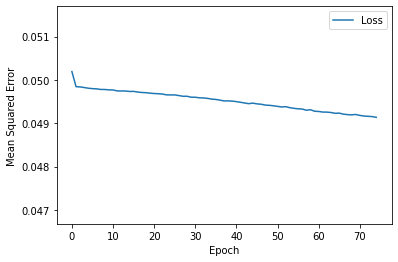

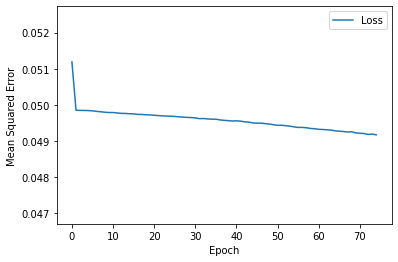

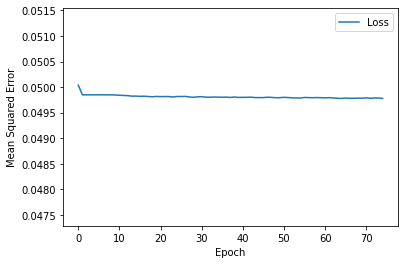

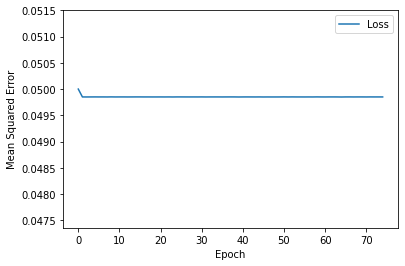

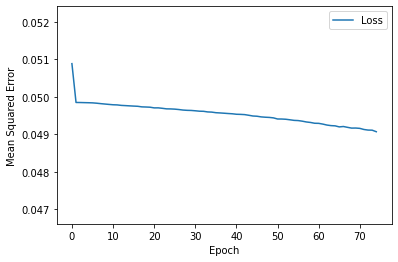

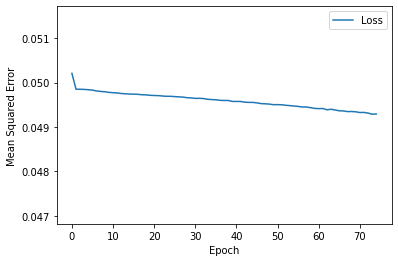

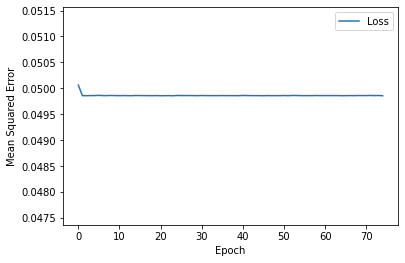

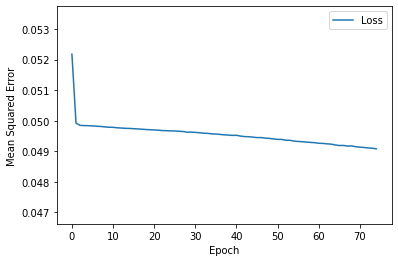

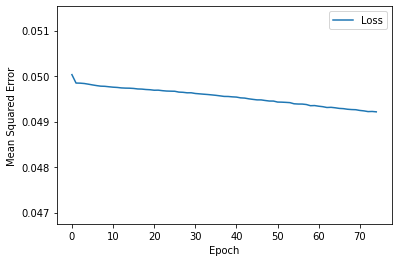

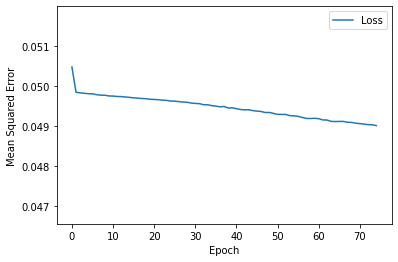

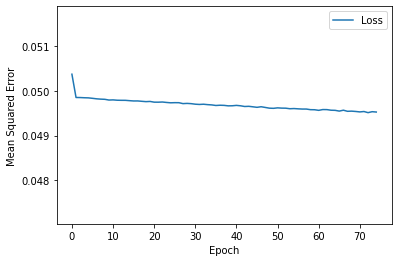

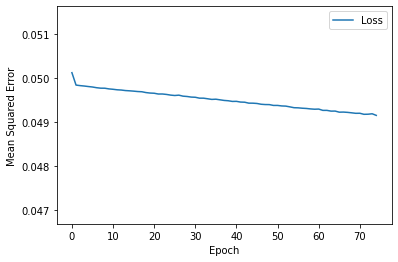

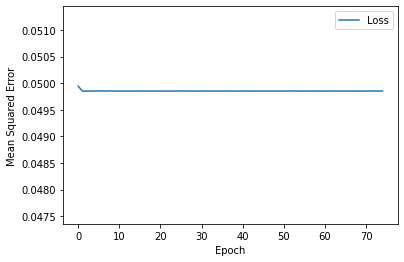

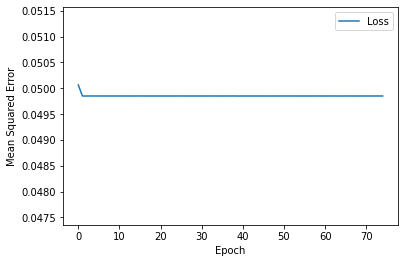

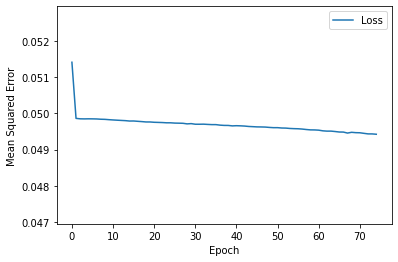

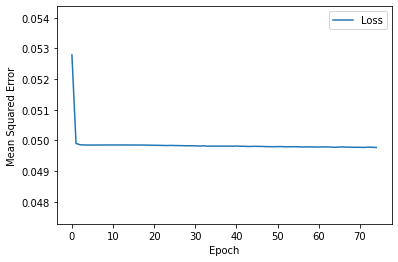

In [27]:
import optuna

def objective(trial):
    model = build_model(
        learning_rate=trial.suggest_loguniform('learning_rate', 0.0001, 0.01), 
        layer_size1=trial.suggest_categorical('layer_size1', [32, 64, 128]), 
        layer_size2=trial.suggest_categorical('layer_size2', [32, 64, 128]), 
        l2=trial.suggest_loguniform('l2', 0.0001, 0.01), 
        dropout=trial.suggest_discrete_uniform('dropout', 0.5, 0.7, 0.1)
    )

    current_epoch, rmse = train_model(model, train_features, train_target, 
                               epochs=75, 
                               batch_size=trial.suggest_int('batch_size', 256, 1024)
                               )
    plot_the_loss_curve(current_epoch, rmse)

    predictions = model.predict(test_df[feature_names])
    test_df[PREDICTION_NAME] = predictions

    test_correlations = test_df.groupby("era").apply(score)
    print(f"On test the correlation has mean {test_correlations.mean()} and std {test_correlations.std()}")
    test_corr_mean = test_correlations.mean()
    test_sharpe = sharpe(test_correlations)
    print('sharpe: ', test_sharpe)
    
    return test_corr_mean

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [28]:
study.best_params

{'batch_size': 579,
 'dropout': 0.6,
 'l2': 0.005953189505330165,
 'layer_size1': 64,
 'layer_size2': 128,
 'learning_rate': 0.00013727720758638801}

In [29]:
model = build_model(
        learning_rate=study.best_params["learning_rate"], 
        layer_size1=study.best_params["layer_size1"], 
        layer_size2=study.best_params["layer_size2"], 
        l2=study.best_params["l2"], 
        dropout=study.best_params["dropout"]
    )

train_model(model, train_features, train_target, 
                               epochs=75, 
                               batch_size=study.best_params["batch_size"]
                               )

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74],
 0     0.051316
 1     0.049868
 2     0.049848
 3     0.049850
 4     0.049850
         ...   
 70    0.049545
 71    0.049529
 72    0.049516
 73    0.049518
 74    0.049500
 Name: mse, Length: 75, dtype: float64)

In [31]:
del training_data, train_features, train_target
gc.collect()

873

Read tournament data

In [32]:
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.00,0.75,0.50,0.25,0.50,0.50,0.25,0.00,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.00,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.00,0.25,0.50,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.50,1.00,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.50,0.00,0.00,0.75,0.25,0.00,0.75,0.50,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.00,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.50,0.25,1.00,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.50,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.50,0.50,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00,1.00,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.50,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.50,0.00,0.00,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.00,0.50,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.00,0.00,0.00,0.50,0.75,1.00,0.75,0.00,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.00,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.00,0.50,0.50,0.25,0.25,0.50,0.50,1.00,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.00,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.50,0.50,0.00,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.00,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.00,0.00,0.25,1.00,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1892082,nffcb3ab61708545,eraX,live,0.50,0.50,0.25,0.75,0.00,0.75,0.75,0.75,0.50,0.50,0.50,0.00,0.00,0.00,0.00,0.75,0.25

set validation data

In [33]:
validation_data = tournament_data[tournament_data['data_type'] == 'validation']
validation_data['era']

0          era121
1          era121
2          era121
3          era121
4          era121
            ...  
1545360    era212
1545361    era212
1545362    era212
1545363    era212
1545364    era212
Name: era, Length: 137779, dtype: object

In [34]:
del tournament_data
gc.collect()

103

In [35]:
np.unique(validation_data['era'].values)

array(['era121', 'era122', 'era123', 'era124', 'era125', 'era126',
       'era127', 'era128', 'era129', 'era130', 'era131', 'era132',
       'era197', 'era198', 'era199', 'era200', 'era201', 'era202',
       'era203', 'era204', 'era205', 'era206', 'era207', 'era208',
       'era209', 'era210', 'era211', 'era212'], dtype=object)

Predict

In [36]:
predictions = model.predict(validation_data[feature_names])
validation_data[PREDICTION_NAME] = predictions

define functions for validation

In [37]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def sharpe(x):
    return np.mean(x)/np.std(x, ddof=1)

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def sortino_ratio(x, target=0.010415154):
   xt = x# - target
   return np.mean(xt) / (np.sum(np.minimum(0, xt)**2)/(len(xt)-1))**.5

def score(df):
    # method="first" breaks ties based on order in array
    pct_ranks = df[PREDICTION_NAME].rank(pct=True, method="first")
    targets = df[TARGET_NAME]
    return np.corrcoef(targets, pct_ranks)[0, 1]

validation

In [38]:
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")

On validation the correlation has mean 0.018003268940487916 and std 0.0242259473999831


era
era121    0.022179
era122    0.013921
era123    0.010931
era124    0.058891
era125    0.005340
era126    0.019424
era127    0.021295
era128    0.045753
era129   -0.007332
era130    0.016433
era131    0.033968
era132    0.028250
era197    0.013683
era198    0.006963
era199   -0.007299
era200    0.019300
era201   -0.000310
era202    0.022636
era203    0.041321
era204    0.008753
era205    0.001090
era206    0.034667
era207    0.042166
era208   -0.003783
era209    0.043529
era210   -0.003661
era211   -0.025411
era212    0.029590
dtype: float64


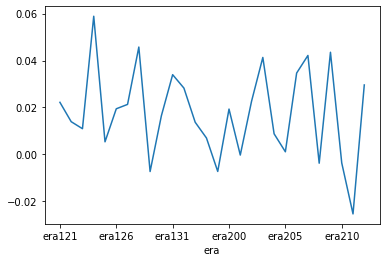

In [45]:
print(validation_correlations)
validation_correlations.plot()

In [40]:
print("sharpe: ", sharpe(validation_correlations))
print("smart sharpe: ", smart_sharpe(validation_correlations))
print("sortino_ratio: ", sortino_ratio(validation_correlations))

sharpe:  0.743139933528481
smart sharpe:  0.7686499656613871
sortino_ratio:  1.879348244160804


Neutralization

In [41]:
from sklearn.preprocessing import MinMaxScaler
def _neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()
def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)
def normalize_and_neutralize(df, columns, by, proportion=1.0):
    # Convert the scores to a normal distribution
    df[columns] = _normalize(df[columns])
    df[columns] = _neutralize(df, columns, by, proportion)
    return df[columns]

In [42]:
import scipy
validation_data["preds"] = predictions
validation_data["preds_neutralized"] = validation_data.groupby("era").apply(
    lambda x: normalize_and_neutralize(x, ["preds"], feature_names, 0.5) # neutralize by 50% within each era
)
scaler = MinMaxScaler()
validation_data["preds_neutralized"] = scaler.fit_transform(validation_data[["preds_neutralized"]]) # transform back to 0-1

In [43]:
validation_data[PREDICTION_NAME] = validation_data['preds_neutralized']
validation_correlations = validation_data.groupby("era").apply(score)
print(f"On validation the correlation has mean {validation_correlations.mean()} and std {validation_correlations.std()}")

On validation the correlation has mean 0.017581751183699215 and std 0.019464175779318468


In [44]:
print("sharpe: ", sharpe(validation_correlations))
print("smart sharpe: ", smart_sharpe(validation_correlations))
print("sortino_ratio: ", sortino_ratio(validation_correlations))

sharpe:  0.9032877314219794
smart sharpe:  1.1106324838076267
sortino_ratio:  3.2700137555493685
